### Gradient Boosting Challenge

This challenge analyzes the European Social Survey Data, using a Gradient Boosting Classifier to predict whether or not someone lives with a partner.

In [24]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [25]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

len(X_train)

7332

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [26]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

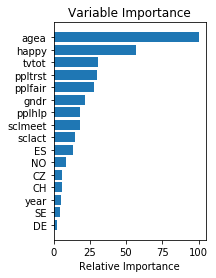

In [27]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### Tune and evaluate the model

We'll use a grid search to tune the hyperparameters of the classifier. First, we'll tune the number of trees, shrinkage (learning rate), and the max depth of each tree. 

In [28]:
#Try to run all at once; at least the three most important. If not, do one at a time and then mess around by hand.
param_test1 = [{'n_estimators':[40, 60, 80, 100], 
                'learning_rate':[0.001, 0.05, 0.1, 0.2],
               'max_depth':[2, 3, 4, 6, 8],
               }]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(min_samples_split=10,
                                                               min_samples_leaf=50,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10, 
                                                               loss='deviance'), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid=[{'n_estimators': [40, 60, 80, 100], 'learning_rate': [0.001, 0.05, 0.1, 0.2], 'max_depth': [2, 3, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [29]:
gsearch1.grid_scores_

[mean: 0.74565, std: 0.01530, params: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 40},
 mean: 0.74913, std: 0.01508, params: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 60},
 mean: 0.75003, std: 0.01553, params: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 80},
 mean: 0.75068, std: 0.01476, params: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100},
 mean: 0.75785, std: 0.01674, params: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 40},
 mean: 0.76113, std: 0.01731, params: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 60},
 mean: 0.76206, std: 0.01570, params: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 80},
 mean: 0.76261, std: 0.01549, params: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100},
 mean: 0.76835, std: 0.01470, params: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 40},
 mean: 0.76905, std: 0.01601, params: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 60}

In [30]:
gsearch1.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 80}

In [31]:
gsearch1.best_score_

0.7873429280570626

A grid search to explore the trade-off between the learning rate and the number of estimators, along with the maximum tree depth, yielded optimal parameters of 0.05, 80, and 6. Let's fit a model with those parameters and see how it fares in cross-validation on the tuning dataset.

In [32]:
clf1 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=10,
                                           min_samples_leaf=50,
                                           n_estimators=80,
                                           max_depth=6,
                                           max_features='sqrt',
                                           subsample=0.8,
                                           random_state=10,
                                           loss='deviance')

clf1.fit(X_train,y_train)
predict_train = clf1.predict(X_train)

print(cross_val_score(clf1, X_train, y_train, cv=5))
print(cross_val_score(clf1, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[ 0.77096115  0.72528971  0.76687117  0.7366985   0.75836177]
0.751636458357
             precision    recall  f1-score   support

        0.0       0.75      0.94      0.84      4508
        1.0       0.84      0.51      0.64      2824

avg / total       0.79      0.77      0.76      7332

Training set accuracy:
Percent Type I errors: 0.03696126568466994
Percent Type II errors: 0.1880796508456083




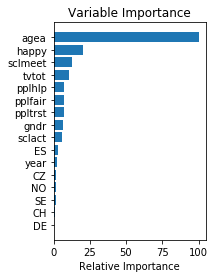

In [33]:
feature_importance = clf1.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We have a somewhat consistent accuracy rating of 75% in the training data, and that the Type I error rates for the training data dropped a tiny bit with the optimized parameters. We can also see that age is disproportionately important in this model, as compared to the untuned model above. 

Let's try some of the parameters related to the estimators and see if we can improve the model.

In [34]:
#Start with smaller number; best things happen between 1 and 6. 
param_test2 = [{'min_samples_split':[10, 50, 100, 200, 400], 
                'min_samples_leaf':[10,20,50,100,200],
               'subsample':[0.7, 0.8, 0.9], 
                'max_features':['sqrt','log2']}]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch2 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                                        n_estimators=80,
                                                                        max_depth=6,
                                                                        random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch2.fit(X_train,y_train)
#print(gsearch2.grid_scores_, '\n', gsearch2.best_params_, '\n', gsearch2.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid=[{'min_samples_split': [10, 50, 100, 200, 400], 'min_samples_leaf': [10, 20, 50, 100, 200], 'subsample': [0.7, 0.8, 0.9], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [35]:
gsearch2.grid_scores_

[mean: 0.77947, std: 0.02969, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'subsample': 0.7},
 mean: 0.77961, std: 0.03057, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'subsample': 0.8},
 mean: 0.77757, std: 0.02900, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'subsample': 0.9},
 mean: 0.78213, std: 0.02756, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'subsample': 0.7},
 mean: 0.77674, std: 0.03214, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'subsample': 0.8},
 mean: 0.77861, std: 0.03025, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'subsample': 0.9},
 mean: 0.78006, std: 0.03344, params: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 100, 'subsample': 0.7},
 mean: 0.77809, std: 0.03199, params: {'max_features': 'sqrt', 'min_samples_leaf':

In [36]:
gsearch2.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'min_samples_split': 200,
 'subsample': 0.7}

In [37]:
gsearch2.best_score_

0.7878858101444541

The optimal values for max_depth and min_samples_split are in fact the ones we used as baselines in our initial model. 

Once again, our original hyperparameters turn out to be the opitmal ones. 

For a final tuning procedure, we'll run the model with the exponential loss function in place of deviance. 

In [38]:
clf2 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=200,
                                           min_samples_leaf=20,
                                           n_estimators=80,
                                           max_depth=6,
                                           max_features='sqrt',
                                           subsample=0.7,
                                           random_state=10,
                                           loss='deviance')

clf2.fit(X_train,y_train)
predict_train = clf2.predict(X_train)

print(cross_val_score(clf2, X_train, y_train, cv=5))
print(cross_val_score(clf2, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[ 0.73892297  0.66189502  0.76209952  0.73942701  0.75426621]
0.731322148526
             precision    recall  f1-score   support

        0.0       0.76      0.94      0.84      4508
        1.0       0.84      0.52      0.64      2824

avg / total       0.79      0.78      0.76      7332

Training set accuracy:
Percent Type I errors: 0.03696126568466994
Percent Type II errors: 0.18630660120021822




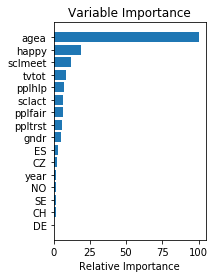

In [39]:
feature_importance = clf2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Here again, the Type I error rate improves, while the Type II error rate gets a little bit worse. Let's run the model on our test data, to see how well it performs.

In [40]:
predict_test = clf2.predict(X_test)

#Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.74      0.90      0.82       505
        1.0       0.76      0.49      0.59       310

avg / total       0.75      0.75      0.73       815

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.19386503067484662




The tuned model performs a little better than the default model with respect to Type I errors, but it is a little worse with respect to Type II errors. Nevertheless, it is better protected from overfitting, so if we were to test it on additional unseen data, it might be more reliable.